<a id='top'></a>

# Structural damping

[Introduction](#Introduction)

[Dynamic equilibrium equation](#Dynamic-equilibrium-equation)

[Computational lab](#Computational-lab)

[Mass proportional damping](#Mass-proportional-damping)

[Stiffness proportional damping](#Stiffness-proportional-damping)

[Rayleigh damping](#Rayleigh-damping)

[Caughey damping](#Caughey-damping)

[References](#References)

[Odds and ends](#Odds-and-ends)

## Introduction

In structural dynamics, mass and stiffness can be computed from the geometric characteristics and material properties of a structure but damping can only be estimated based on the fact that structural dynamic responses are, well, damped. It is usually assumed that structural damping is viscous, in the absence of more accurate information, which fits nicely in the [dynamic equilibrium equation](#Dynamic-equilibrium-equation) classical solution.

This python notebook will explore the following types of viscous damping in the computation of the dynamic responses of multi-degree-of-freedom systems:

1. [Mass proportional damping](#Mass-proportional-damping)
2. [Stiffness proportional damping](#Stiffness-proportional-damping)
3. [Rayleigh damping](#Rayleigh-damping)
4. [Caughey damping](#Caughey-damping)

When using any of these types of damping, the damping matrix is orthogonal to the modal matrix and, therefore, it is diagonalizable. This constitutes a clear advantage when it comes to solving the dynamic equilibrium equation system for multi-degree-of-freedom systems.

[Back to top](#top)

## Dynamic equilibrium equation

In structural dynamics the second order differential dynamic equilibrium equation can be written in terms of generalized coordinates (d[isplacement]) and their first (v[elocity]) and second (a[cceleration]) time derivatives:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \mathbf{C} \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

where:

> $\mathbf{M}$ is the mass matrix  
> $\mathbf{C}$ is the damping matrix  
> $\mathbf{K}$ is the stiffness matrix  
> $\mathbf{a(t)}$ is the acceleration vector  
> $\mathbf{v(t)}$ is the velocity vector  
> $\mathbf{d(t)}$ is the displacement vector  
> $\mathbf{F(t)}$ is the force input vector  

In a multi-degree-of-freedom dynamic system all these matrices are of size $NDOF \times NDOF$, where $NDOF$ is the number of generalized degrees of freedom. Carrying out the usual coordinate transformation from generalized coordinates to modal coordinates, $\mathbf{d(t)} = \mathbf{\Phi}^T \times \mathbf{q(t)}$, and pre-multiplying by the transpose of the modal matrix, $\mathbf{\Phi}^T$, one obtains the following:

\begin{equation}
\mathbf{\Phi}^T \times \mathbf{M} \times \mathbf{\Phi} \times \mathbf{\ddot q(t)} + \mathbf{\Phi}^T \times \mathbf{C} \times \mathbf{\Phi} \times \mathbf{\dot q(t)} + \mathbf{\Phi}^T \times \mathbf{K} \times \mathbf{\Phi} \times \mathbf{q(t)} = \mathbf{\Phi}^T \times \mathbf{F(t)}
\end{equation}

where:

> $\mathbf{\Phi}^T \times \mathbf{M} \times \mathbf{\Phi} = \mathbf{M_n}$ is a diagonal matrix (with modal mass in the main diagonal)  
> $\mathbf{\Phi}^T \times \mathbf{K} \times \mathbf{\Phi} = \mathbf{K_n}$ is a diagonal matrix (with modal stiffness in the main diagonal)  

On the contrary, the product $\mathbf{\Phi}^T \times \mathbf{C} \times \mathbf{\Phi}$ is a diagonal matrix (with modal damping in the main diagonal) only in certain circunstances. This is achieved when damping is "proportional" to either the mass or the stiffness or a combination of both.

When this happens, the previous dynamic equilibrium equation system transforms into a set of $NDOF$ one-degree-of-freedom independent dynamic equilibrium equations (modal equations):

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q(t)} + \mathbf{C_n} \times \mathbf{\dot q(t)} + \mathbf{K_n} \times \mathbf{q(t)} = \mathbf{F_n(t)}
\end{equation}

The $NDOF$ independent modal equilibrium equations can be rewritten as:

\begin{equation}
\mathbf{\ddot q(t)} + \mathbf{2 \times \zeta_n \times \omega_n} \times \mathbf{\dot q(t)} + \mathbf{\omega_n^2} \times \mathbf{q(t)} = \mathbf{a_n(t)}
\end{equation}

where:

> $\zeta_n$ is the modal damping coefficient of mode $N$  
> $\omega_n$ is the modal angular frequency of mode $N$  
> $a_n(t)$ is the modal excitation of mode $N$  

The solution of these $NDOF$ independent dynamic equilibrium equations is:

\begin{equation}
\mathbf{q(t)} = \mathbf{q(t)}
\end{equation}

[Back to top](#top)

## Computational lab

Before proceeding any further, let us set the computational lab:

In [1]:
import sys
import math
import numpy as np
import matplotlib as mpl
print('System: {}'.format(sys.version))
for package in (np, mpl):
    print('Package: {} {}'.format(package.__name__, package.__version__))

System: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
Package: numpy 1.11.2
Package: matplotlib 1.5.3


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

ff = np.linspace(0.01, 3.97, num=397)
wn = 2.*np.pi*ff

[Back to top](#top)

## Mass proportional damping

Mass proportional damping means that damping is somehow a multiple of the mass:

\begin{equation}
\mathbf{C} = \alpha \times \mathbf{M}
\end{equation}

where $\alpha$ is the constant of mass proportionality. In these circunstances, the dynamic equilibrium equation can be written as:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \alpha \times \mathbf{M} \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

Proceeding the same as above, one obtains the $NDOF$ independent modal equilibrium equations:

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q_n(t)} + \alpha \times \mathbf{M_n} \times \mathbf{\dot q_n(t)} + \mathbf{K_n} \times \mathbf{q_n(t)} = \mathbf{F_n(t)}
\end{equation}

or, equivalently:

\begin{equation}
\mathbf{\ddot q_n(t)} + \alpha \times \mathbf{\dot q_n(t)} + \mathbf{\omega_n^2} \times \mathbf{q_n(t)} = \mathbf{a_n(t)}
\end{equation}

Comparing expressions, it can be seen that

\begin{equation}
\alpha = 2 \times \zeta_n \times \omega_n \Leftrightarrow \zeta_n = \frac{\alpha}{2 \times \omega_n}
\end{equation}

that is, the damping is a hyperbolic function of the vibration frequency $\omega_n$.

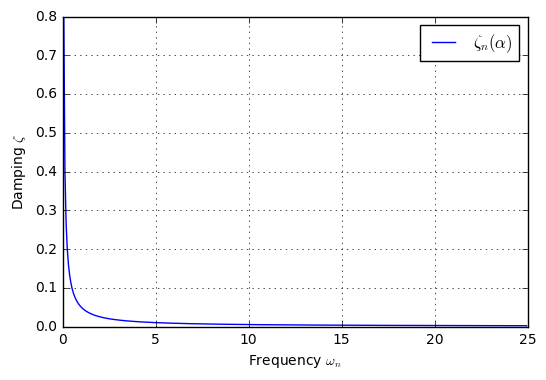

In [3]:
alpha = 0.1
zn_a = alpha/(2.*wn)
plt.plot(wn, zn_a, label='$\\zeta_n ( \\alpha )$')
plt.xlabel('Frequency $\\omega_n$')
plt.ylabel('Damping $\\zeta$')
plt.legend()
plt.grid(True)
plt.show()

[Back to top](#top)

## Stiffness proportional damping

Stiffness proportional damping means that damping is somehow a multiple of stiffness:

\begin{equation}
\mathbf{C} = \beta \times \mathbf{K}
\end{equation}

where $\beta$ is the constant of stiffness proportionality. In these circunstances, the dynamic equilibrium equation can be written as:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \beta \times \mathbf{K} \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

Proceeding the same as above, one obtains the $NDOF$ independent modal equilibrium equations:

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q_n(t)} + \beta \times \mathbf{K_n} \times \mathbf{\dot q_n(t)} + \mathbf{K_n} \times \mathbf{q_n(t)} = \mathbf{F_n(t)}
\end{equation}

or, equivalently:

\begin{equation}
\mathbf{\ddot q_n(t)} + \beta \times \mathbf{\omega_n^2} \times \mathbf{\dot q_n(t)} + \mathbf{\omega_n^2} \times \mathbf{q_n(t)} = \mathbf{a_n(t)}
\end{equation}

Comparing expressions, it can be seen that

\begin{equation}
\beta \times \omega_n^2 = 2 \times \zeta \times \omega_n \Leftrightarrow \zeta_n = \frac{\omega_n \times \beta}{2}
\end{equation}

that is, the damping is a linear function of the vibration frequency $\omega_n$.

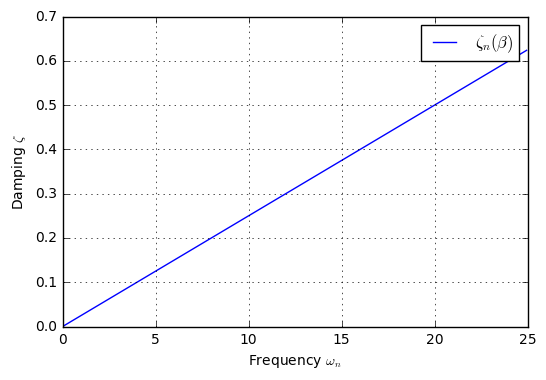

In [4]:
beta = 0.05
zn_b = (beta*wn)/2.
plt.plot(wn, zn_b, label='$\\zeta_n ( \\beta )$')
plt.xlabel('Frequency $\\omega_n$')
plt.ylabel('Damping $\\zeta$')
plt.legend()
plt.grid(True)
plt.show()

[Back to top](#top)

## Rayleigh damping

When Rayleigh damping is considered it means that the damping coefficient is a combination of the two previous ones, that is, it is a multiple of mass and stifnness:

\begin{equation}
\mathbf{C} = \alpha \times \mathbf{M} + \beta \times \mathbf{K}
\end{equation}

where $\alpha$ and $\beta$ have the previous meanings. In these circunstances, the dynamic equilibrium equation can be written as:

\begin{equation}
\mathbf{M} \times \mathbf{a(t)} + \left[ \alpha \times \mathbf{M} + \beta \times \mathbf{K} \right] \times \mathbf{v(t)} + \mathbf{K} \times \mathbf{d(t)} = \mathbf{F(t)}
\end{equation}

Proceeding the same as above, one obtains the $NDOF$ independent modal equilibrium equations:

\begin{equation}
\mathbf{M_n} \times \mathbf{\ddot q_n(t)} + \left[ \alpha \times \mathbf{M_n} + \beta \times \mathbf{K_n} \right] \times \mathbf{\dot q_n(t)} + \mathbf{K_n} \times \mathbf{q_n(t)} = \mathbf{F_n(t)}
\end{equation}

or, equivalently:

\begin{equation}
\mathbf{\ddot q_n(t)} + \left[ \alpha + \beta \times \mathbf{\omega_n^2} \right] \times \mathbf{\dot q_n(t)} + \mathbf{\omega_n^2} \times \mathbf{q_n(t)} = \mathbf{a_n(t)}
\end{equation}

Comparing expressions, it can be seen that

\begin{equation}
\alpha + \beta \times \omega_n^2 = 2 \times \zeta \times \omega_n \Leftrightarrow \zeta_n = \frac{\alpha}{2 \times \omega_n} + \frac{\omega_n \times \beta}{2}
\end{equation}

that is, the damping is the sum of the previous linear and hyperbolic functions of the vibration frequency $\omega_n$.

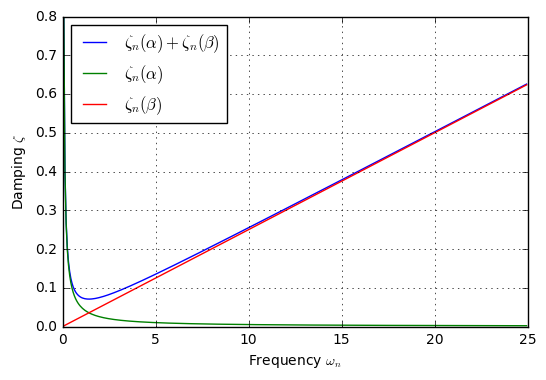

In [5]:
plt.hold(True)
plt.plot(wn, zn_a+zn_b, label='$\\zeta_n ( \\alpha ) + \\zeta_n ( \\beta )$')
plt.plot(wn, zn_a, label='$\\zeta_n ( \\alpha )$')
plt.plot(wn, zn_b, label='$\\zeta_n ( \\beta )$')
plt.xlabel('Frequency $\omega_n$')
plt.ylabel('Damping $\zeta$')
plt.legend(loc='best')
plt.grid(True)
plt.show()

[Back to top](#top)

## Caughey damping

TBD: [Caughey damping][1], a.k.a. extended Rayleigh damping, 

\begin{equation}
\mathbf{C} = \mathbf{M} \sum_{j=0}^{N-1}{\alpha_j \left[ M^{-1}K \right]^j}
\end{equation}

[1]: Caughey, T.K. “Classical Normal Modes in Damped Linear Dynamic Systems,” Journal of Applied Mechanics, 27(2)(1960): 269–271


[Back to top](#top)

## References:

http://www.sciencedirect.com/science/article/pii/S0020768313003727

http://www.sandv.com/downloads/1306schw.pdf

http://engweb.swan.ac.uk/~adhikaris/fulltext/conference/ftc27.pdf

https://wiki.csiamerica.com/display/kb/Damping+coefficients

https://www.orcina.com/SoftwareProducts/OrcaFlex/Documentation/Help/Content/html/RayleighDamping,Guidance.htm

[Back to top](#top)

## Odds and ends

This notebook was created by Paulo Xavier Candeias.

[Back to top](#top)